# Example 1: Intersecting Gaussians with a prior

### function to sample from the product of two guassian

In [1]:
from scipy.stats import multivariate_normal
def sample_from_product_gaussian(mu1, Sigma1, mu2, Sigma2, n_samples):
    """
    Sample from the product of two Gaussian distributions.

    Parameters:
    mu1 (array): Mean vector of the first Gaussian distribution.
    Sigma1 (array): Covariance matrix of the first Gaussian distribution.
    mu2 (array): Mean vector of the second Gaussian distribution.
    Sigma2 (array): Covariance matrix of the second Gaussian distribution.
    n_samples (int): Number of samples to draw from the resulting Gaussian.

    Returns:
    array: Samples from the resulting product Gaussian distribution.
    """
    # Calculate the inverse of the covariances
    Sigma1_inv = np.linalg.inv(Sigma1)
    Sigma2_inv = np.linalg.inv(Sigma2)

    # Calculate the covariance of the resulting distribution
    Sigma3_inv = Sigma1_inv + Sigma2_inv
    Sigma3 = np.linalg.inv(Sigma3_inv)

    # Calculate the mean of the resulting distribution
    mu3 = Sigma3.dot(Sigma1_inv.dot(mu1) + Sigma2_inv.dot(mu2))

    # Create the resulting Gaussian distribution
    resulting_distribution = multivariate_normal(mean=mu3, cov=Sigma3)

    # Sample from the resulting distribution
    samples = resulting_distribution.rvs(size=n_samples)

    return samples



def product_gaussian(mu1, Sigma1, mu2, Sigma2):
    """
    Sample from the product of two Gaussian distributions.

    Parameters:
    mu1 (array): Mean vector of the first Gaussian distribution.
    Sigma1 (array): Covariance matrix of the first Gaussian distribution.
    mu2 (array): Mean vector of the second Gaussian distribution.
    Sigma2 (array): Covariance matrix of the second Gaussian distribution.
    n_samples (int): Number of samples to draw from the resulting Gaussian.

    Returns:
    array: Samples from the resulting product Gaussian distribution.
    """
    # Calculate the inverse of the covariances
    Sigma1_inv = np.linalg.inv(Sigma1)
    Sigma2_inv = np.linalg.inv(Sigma2)

    # Calculate the covariance of the resulting distribution
    Sigma3_inv = Sigma1_inv + Sigma2_inv
    Sigma3 = np.linalg.inv(Sigma3_inv)

    # Calculate the mean of the resulting distribution
    mu3 = Sigma3.dot(Sigma1_inv.dot(mu1) + Sigma2_inv.dot(mu2))

    return mu3, Sigma3




### make the two Gaussian distributions and plot some samples assuming a Gaussian prior 

(2,)
(2,)


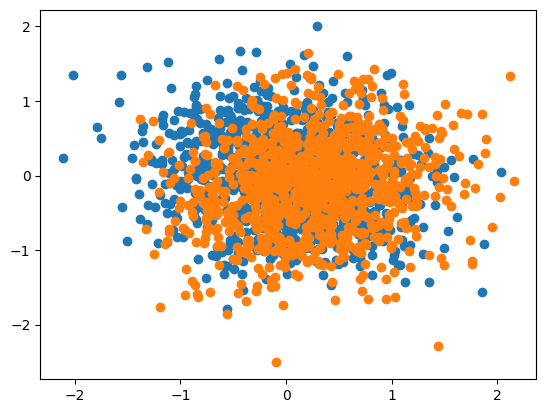

In [2]:
import numpy as np
from matplotlib import pyplot as plt

mean1 = np.zeros(2)
mean2 = np.array([1,0])

cov1 = np.array([[1, 0], [0, 4]])
cov2 = np.array([[3, 0], [0, 1]])

#Gaussian prior
mean_prior = np.zeros(2)
cov_prior =  0.5 * np.eye(2)

print(np.shape(mean1))
print(np.shape(mean_prior))


# Rotation angle
theta = np.pi / 4  # 45 degrees in radians

# Rotation matrix
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Function to rotate covariance matrix
def rotate_covariance(cov, R):
    return R @ cov @ R.T

# Rotate cov1 and cov2
cov1 = rotate_covariance(cov1, R)
cov2 = rotate_covariance(cov2, R)

samples1 = sample_from_product_gaussian(mean1, cov1, mean_prior, cov_prior, 1000)
samples2 = sample_from_product_gaussian(mean2, cov2, mean_prior, cov_prior, 1000)
plt.scatter(samples1[:,0], samples1[:,1])
plt.scatter(samples2[:,0], samples2[:,1])

### Run CombineHarvesterFlow

In [3]:
from CombineHarvesterFlow import Harvest
from CombineHarvesterFlow import Combine
import getdist.plots as gdplt
from getdist import MCSamples


num_samples = 20000


#sample from the distributions
wheat_chain = sample_from_product_gaussian(mean1, cov1, mean_prior, cov_prior, num_samples)
barley_chain = sample_from_product_gaussian(mean2, cov2, mean_prior, cov_prior, num_samples)



truth_chains_no_prior = sample_from_product_gaussian(mean1, cov1, mean2, cov2, num_samples)

#initiate the the class
Wheat = Harvest('output/Wheat', chain = wheat_chain, n_flows = 7) 
Barley = Harvest('output/Barley', chain = barley_chain, n_flows = 7)


#train the flows
Wheat.harvest()
Barley.harvest()

#combine
Grain = Combine(Wheat, Barley)
wheat_weights, barley_weights = Grain.combine()



Training the flows


 14%|█████▉                                    | 14/100 [00:13<01:25,  1.01it/s, train=2.842724, val=2.8503206 (Max patience reached)]


Training the flows


 10%|████                                     | 10/100 [00:11<01:39,  1.11s/it, train=2.8390589, val=2.8563778 (Max patience reached)]


### Compute the prior, so we can devide out by the prior to avoid double counting

In [5]:
from scipy.stats import multivariate_normal

def compute_2d_gaussian_density(data, mean, cov):
    # Define the Gaussian distribution with the given mean and covariance
    gaussian_dist = multivariate_normal(mean=mean, cov=cov)
    
    # Evaluate the density of this distribution at each data point
    densities = gaussian_dist.pdf(data)
    
    return densities


# compute the prior density for wheat and barley
wheat_prior_weights = compute_2d_gaussian_density(wheat_chain, mean_prior, cov_prior)
barley_prior_weights = compute_2d_gaussian_density(barley_chain, mean_prior, cov_prior)

#compute the prior of the true combined chains 
truth_weights = compute_2d_gaussian_density(truth_chains_no_prior, mean_prior, cov_prior)

### Make the plots

In [7]:
plt.rc('text', usetex=True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


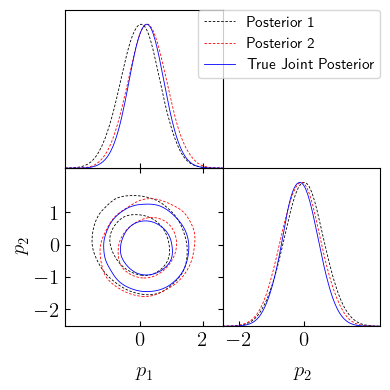

In [9]:
import getdist.plots as gdplt
from getdist import MCSamples

wheat = MCSamples(samples=wheat_chain)
barley = MCSamples(samples=barley_chain)
#devide through by the prior at the sampled points to avoid double counting
weighted_wheat =  MCSamples(samples=wheat_chain, weights=wheat_weights / wheat_prior_weights)
weighted_barley =  MCSamples(samples=barley_chain, weights=barley_weights / barley_prior_weights)
#apply the prior to the truth to get the true posterior
truth = MCSamples(samples=truth_chains_no_prior, weights = truth_weights)


g = gdplt.get_subplot_plotter()

g.settings.axes_fontsize = 18  
g.settings.lab_fontsize = 18    
g.settings.legend_fontsize = 14 

line_styles = ['--', '--', '-']
g.triangle_plot([wheat, barley, truth], filled=False, \
                legend_labels=['Posterior 1', 'Posterior 2',  'True Joint Posterior'], contour_ls=line_styles )

#plt.savefig('plots/toy_1.pdf')
plt.show()

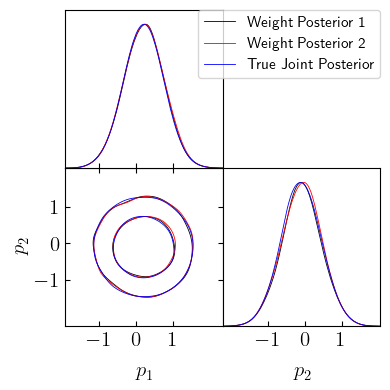

In [10]:
g.triangle_plot([weighted_wheat, weighted_barley, truth], filled=False, \
                legend_labels=['Weight Posterior 1', 'Weight Posterior 2',  ' True Joint Posterior'])
plt.show()